In [ ]:
import sys
sys.path.append('../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path

from utils import parse, processing, plotting_utils as plotting, AddExtraColumns

import plots_preward as plots_preward

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from tkinter import font
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter, MaxNLocator, FixedLocator
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from scipy.optimize import curve_fit
import math 

from numpy.typing import ArrayLike
from typing import Literal, Tuple

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from IPython.display import display
from matplotlib.patches import Rectangle

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = 'Z:/scratch/vr-foraging/data/'

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
odor_list_color = [color1, color2, color3]
color_dict = {0: color1, 1: color2, 2: color3}
color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3}

# Define exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def format_func(value, tick_number):
    return f"{value:.0f}"

foraging_figures = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\results'


# Batch 3 - Preward depletion with three odors. 

## Exploration with one session only

### Are the statistics that we impose the ones that the animals experience?

In [ ]:
date_string = "5/28/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()
mouse = '713545'

In [ ]:
session_found = False

directory = os.path.join(base_path, mouse)
files = os.listdir(os.path.join(base_path, mouse))

sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)

for file_name in sorted_files:
    
    if session_found == True:
        break
    
    print(file_name)
    session_path = os.path.join(base_path, mouse, file_name)
    session = file_name[:8]
    session_path = Path(session_path)
    
    if datetime.date.fromtimestamp(os.path.getctime(session_path)) != date:
        continue
    else:
        print('correct date found')
        session_found = True

    data = parse.load_session_data(session_path)    
    reward_sites, active_site, config = parse.parse_dataframe(data)
    reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
    encoder_data = parse.ContinuousData(data).encoder_data

In [ ]:
reward_sites.groupby('odor_label').reward_probability.mean()

In [ ]:
dict_odor = {}
for i in range(len(data['config'].streams.tasklogic_input.data['environment_statistics']['patches'])):
    odor_label = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i]['label']
    rate = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['c']
    offset = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['a']
    dict_odor[odor_label] = {'rate':rate, 'offset':offset, 'color': color_dict_label[odor_label]}

### Theoretical values extracted from an example session

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
max_visit = 30
height = 0.8
x_values = np.linspace(0, max_visit, max_visit)

for odor in dict_odor.keys():
    # Plot curve for this odor in theroy
    rate = dict_odor[odor]['rate']
    offset = dict_odor[odor]['offset']
    # Calculate y values using the power function y = ax^b
    y_values = offset * np.power(math.e, x_values* rate)
    ax.plot(x_values, y_values, color=dict_odor[odor]['color'], alpha=0.6, label='Exponential Fit', marker='o')

    ax.text(5, height, f'y = {offset} * e^({rate} * x)', color=dict_odor[odor]['color'], fontsize=10, )
    height +=0.05

plt.xlabel('Visit Number')
plt.ylabel('Percent Collected')
sns.despine()

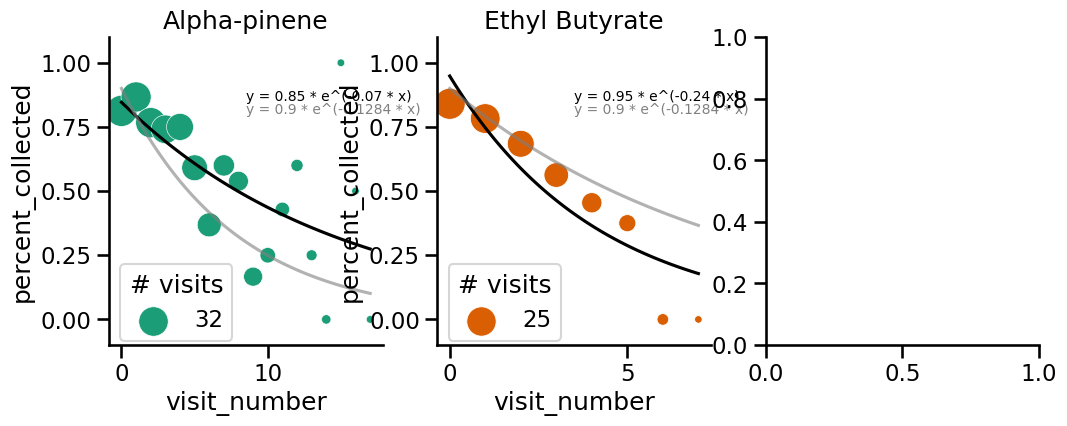

In [20]:
reward_sites = reward_sites.loc[reward_sites.has_choice == True]

summary = reward_sites.groupby(['visit_number','odor_label']).agg({'reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['visit_number']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(12, 4))
i = 0
for odor in dict_odor.keys():

    odor_df = summary.loc[summary['odor_label'] == odor]
    # odor_df = odor_df.loc[~((odor_df.percent_collected == 1.0)&(odor_df.visit_number > 10))]
    odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]
    if odor_df.empty:
        continue
    
    sns.scatterplot(odor_df, x='visit_number', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
    
    # Plot exponential curve
    popt, pcov = curve_fit(exponential_func, odor_df['visit_number'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
    
    # Plot curve for this odor in theroy
    rate = dict_odor[odor]['rate']
    offset = dict_odor[odor]['offset']
    if popt[1] < 0:
        x_values = np.linspace(odor_df['visit_number'].min(), odor_df['visit_number'].max(), 100)
        ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
        ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
        ax[i].text(max(odor_df.visit_number)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
        ax[i].text(max(odor_df.visit_number)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

    ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_title(odor)
    sns.despine()
    i += 1

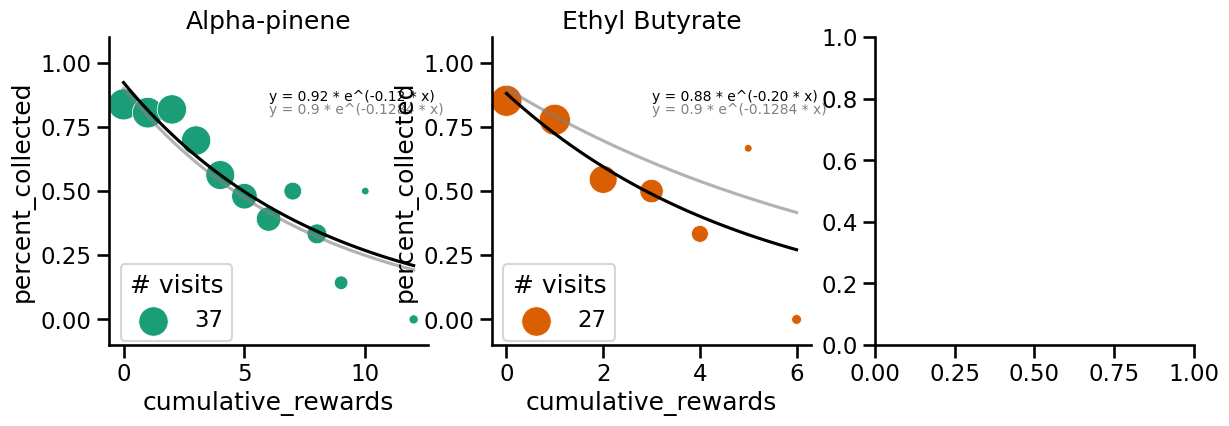

In [19]:
dict_odor = {}
for i in range(len(data['config'].streams.tasklogic_input.data['environment_statistics']['patches'])):
    odor_label = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i]['label']
    rate = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['c']
    offset = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['a']
    dict_odor[odor_label] = {'rate':rate, 'offset':offset, 'color': color_dict_label[odor_label]}

summary = reward_sites.groupby(['cumulative_rewards','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(14, 4))
i = 0
for odor in dict_odor.keys():
    odor_df = summary.loc[summary['odor_label'] == odor]
    # odor_df = odor_df.loc[~((odor_df.percent_collected == 1.0)&(odor_df.visit_number > 10))]
    odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]
    if odor_df.empty:
        continue
    
    sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
    
    # Plot exponential curve
    popt, pcov = curve_fit(processing.exponential_func, odor_df['cumulative_rewards'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
    
    # Plot curve for this odor in theroy
    rate = dict_odor[odor]['rate']
    offset = dict_odor[odor]['offset']
    if popt[1] < 0:
        x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
        ax[i].plot(x_values, processing.exponential_func(x_values, *popt), color='black', label='Exponential Fit')
        ax[i].plot(x_values, processing.exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
        ax[i].text(max(odor_df.cumulative_rewards)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
        ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

    ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_title(odor)
    sns.despine()
    i += 1

### What is the velocity of the mouse during interpatch epochs

In [ ]:
trial_summary = plotting.trial_collection(active_site.loc[active_site.label == 'InterPatch'], encoder_data, mouse, session, window=(-0.5,2))

## What is the reward rate per patch time

In [ ]:
def round_to_pair(arr, values):
    # Round each element in the array to the nearest even number
    rounded_array = np.round(arr / values) * values
    return rounded_array.astype(int)

In [ ]:
count = 0
initial_time_patch = 0
reward_sites['cumulative_reward'] = 0
reward_sites['time_elapsed_patch'] = 0
reward_sites['position_elapsed_patch'] = 0

for i, row in reward_sites.iterrows():
    if row['visit_number'] == 0:
        initial_time_patch = i
        initial_position_patch = row['start_position']
        count = 0
    count += row['reward_delivered']
    reward_sites.at[i, 'cumulative_reward'] = count 
    
    reward_sites.at[i, 'position_elapsed_patch'] = round_to_pair(row['start_position'] - initial_position_patch, 2)
    
    if row['stop_time'] is not None:
        reward_sites.at[i, 'time_elapsed_patch'] = round_to_pair(row['stop_time'] - initial_time_patch, 2)
    else:
        try:
            reward_sites.at[i, 'time_elapsed_patch'] = round_to_pair(row['odor_offset'] - initial_time_patch, 2)
        except:
            reward_sites.at[i, 'time_elapsed_patch'] = round_to_pair(i - initial_time_patch, 2)

In [ ]:
reward_sites['last_site'] = reward_sites['visit_number'].shift(-1)
reward_sites['last_site'] = np.where(reward_sites['last_site'] == 0, 1,0)

In [ ]:
reward_sites['reward_rate_time'] = reward_sites['cumulative_reward'] / reward_sites['time_elapsed_patch']
reward_sites['reward_rate_position'] = reward_sites['cumulative_reward'] / reward_sites['position_elapsed_patch']
reward_sites['reward_rate_visit'] = reward_sites['cumulative_reward'] / (reward_sites['visit_number'] + 1)

In [ ]:
reward_sites = reward_sites.loc[reward_sites.odor_label != 'Amyl Acetate']
reward_sites = reward_sites.loc[(reward_sites.visit_number != 0)|(reward_sites.has_choice == True)]

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(14,4), sharex=True)
for odor, color in zip(reward_sites.odor_label.unique(),[color1,color2]):
    odor_df = reward_sites.loc[reward_sites.odor_label == odor]
    sns.lineplot(x = 'cumulative_rewards', y = 'reward_rate_visit', data=odor_df, linewidth = 0.6, color = color , marker = 'o', legend=False, ax = ax[0])
    ax[0].hlines(y = odor_df.loc[odor_df.last_site == 1].reward_rate_visit.mean(), xmin = 0, xmax = 10, color = color , linestyle='--')
    # ax[0].set_xlim('Visit number')
    # ax[0].set_ylim('Reward rate (rewards/visit)')

    sns.lineplot(x = 'cumulative_rewards', y = 'reward_rate_time', data=odor_df, linewidth = 0.6, marker = 'o', color = color , legend=False, ax = ax[1])
    ax[1].hlines(y = odor_df.loc[odor_df.last_site == 1].reward_rate_time.median(), xmin = 0, xmax = 10,  color = color , linestyle='--')
    # ax[1].set_xlim('Visit number')
    # ax[1].set_ylim('Reward rate (rewards/time)')
    
    sns.lineplot(x = 'cumulative_rewards', y = 'reward_rate_position', data=odor_df, linewidth = 0.6, marker = 'o', color = color , legend=False, ax = ax[2])
    ax[2].hlines(y = odor_df.loc[odor_df.last_site == 1].reward_rate_position.mean(), xmin = 0, xmax = 10,  color = color , linestyle='--')
    # ax[2].set_xlim('Visit number')
    # ax[2].set_ylim('Reward rate (rewards/position)')

sns.despine()
plt.tight_layout()

## Perceived preward versus real probability of reward

In [ ]:
reward_sites['perceived_reward_probability'] = reward_sites['patch_success_number'] / (reward_sites['visit_number'] +1)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True)

df = reward_sites.loc[(reward_sites.last_visit == 1)].groupby(['active_patch', 'odor_label']).agg({'perceived_reward_probability':'mean'}).reset_index()
df['visit_number'] = reward_sites.loc[(reward_sites.has_choice == True)].groupby(['active_patch', 'odor_label']).agg({'visit_number':'count'})['visit_number'].values[:len(df)]
df = df.loc[df['visit_number']>1]

sns.scatterplot(x='active_patch', y='perceived_reward_probability', size="visit_number", sizes=(10, 300), data=df, hue='odor_label', palette=[color1, color2, color3], ax = ax[0], legend=False)
ax[0].set_ylabel('Perceived reward probability')
ax[0].set_xlabel('Patch number')
ax[0].set_ylim(-0.1,1.1)

odor_p = df.groupby(['odor_label']).agg({'perceived_reward_probability':'mean'}).reset_index()

if 'Alpha-pinene' in odor_p.odor_label.values:
    alpha = odor_p.loc[odor_p.odor_label == 'Alpha-pinene']['perceived_reward_probability'].values[0]
else:
    alpha = 0
ethyl = odor_p.loc[odor_p.odor_label == 'Ethyl Butyrate']['perceived_reward_probability'].values[0]
ax[0].text(0.5, 0.1, fontsize=10, s=f'Alpha-pinene {alpha:.2f}\nEthyl Butyrate {ethyl:.2f}', transform=ax[0].transAxes)

# Same for the perceived reward probability
df = reward_sites.loc[(reward_sites.visit_number != 0)].groupby(['active_patch', 'odor_label']).agg({'reward_probability':'min', 'visit_number':'count'}).reset_index()
df['visit_number'] += 1
df = df.loc[df['visit_number']>2]

sns.scatterplot(x='active_patch', y='reward_probability', size="visit_number", sizes=(10, 300), data=df, hue='odor_label', palette=[color1, color2, color3], ax = ax[1])
ax[1].set_ylabel('Reward probability')
ax[1].set_xlabel('Patch number')
ax[1].set_ylim(-0.1,1.1)

odor_p = df.groupby(['odor_label']).agg({'reward_probability':'mean'}).reset_index()
if 'Alpha-pinene' in odor_p.odor_label.values:
    alpha = odor_p.loc[odor_p.odor_label == 'Alpha-pinene']['reward_probability'].values[0]
else:
    alpha = 0
ethyl = odor_p.loc[odor_p.odor_label == 'Ethyl Butyrate']['reward_probability'].values[0]
ax[1].text(1.5, 0.1, fontsize=10, s=f'Alpha-pinene {alpha:.2f}\nEthyl Butyrate {ethyl:.2f}', transform=ax[0].transAxes)

plt.legend(bbox_to_anchor=(1.0,0.8), loc='upper left', labels=[max(df.visit_number)], markerscale=1.3, title='# visits')
plt.suptitle(f'{mouse} {session} - Reward probability upon leaving patch')
sns.despine()


In [ ]:
df = reward_sites.loc[(reward_sites.last_visit == 1)].groupby(['active_patch', 'odor_label']).agg({'perceived_reward_probability':'mean', 'reward_probability':'mean'}).reset_index()

fig = plt.figure(figsize=(16,4))
# Define the x coordinates
# Plot the first set of values
sns.lineplot(x='active_patch', y='perceived_reward_probability', marker='',color='black', alpha=0.5, data = df, ax = plt.gca(), legend=False)
sns.scatterplot(x='active_patch', y='perceived_reward_probability', edgecolor='black', marker='s',color='b', hue='odor_label', zorder=10, palette=[color1, color2], data = df, ax = plt.gca(), legend=False)

sns.scatterplot(x='active_patch', y='reward_probability', color='b', s=220, marker='*',  zorder=10, hue='odor_label', palette=[color1, color2], data = df, ax = plt.gca())
sns.lineplot(x='active_patch', y='reward_probability', marker='',color='yellow', alpha=0.5, data = df, ax = plt.gca(), legend=False)

plt.xlabel('Patch number')
plt.ylabel('Reward probability')
sns.despine()


In [ ]:
df = reward_sites.loc[(reward_sites.last_visit == 1)].groupby(['active_patch', 'odor_label']).agg({'perceived_reward_probability':'mean'}).reset_index()
df['reward_probability'] = reward_sites.loc[(reward_sites.visit_number != 0)].groupby(['active_patch', 'odor_label']).agg({'reward_probability':'min'}).reset_index()['reward_probability']

fig, ax = plt.subplots(1,2, figsize=(18,6), gridspec_kw={'width_ratios': [3, 1]})
# Define the x coordinates
x = df.active_patch

# Define the y coordinates for two sets of values
y1 = df.perceived_reward_probability
y2 = df.reward_probability

# Connect the two sets of values with lines
for i in range(len(x)):
    ax[0].plot([x[i], x[i]], [y1[i], y2[i]], color='black', linestyle='-', alpha=0.5)

# Plot the first set of values
sns.scatterplot(x='active_patch', y='perceived_reward_probability', edgecolor='black', marker='s',color='b', hue='odor_label', palette=[color1, color2, color3], data = df, ax = ax[0], legend=False, label='Perceived reward probability')
sns.scatterplot(x='active_patch', y='reward_probability', edgecolor='black', marker='*',color='b', hue='odor_label', palette=[color1, color2, color3], data = df, ax = ax[0], legend=False, label='Real reward probability')
sns.scatterplot(x='active_patch', y='reward_probability', color='b', s=220, marker='*', zorder=10, hue='odor_label', palette=[color1, color2, color3], data = df, ax = ax[0])

ax[0].set_xlabel('Patch number')
ax[0].set_ylabel('Reward probability')
ax[0].legend(bbox_to_anchor=(0.3,-0.15), loc='upper left', ncols=2)

sns.scatterplot(x=df['perceived_reward_probability'].values, y=df['reward_probability'].values, data = df, hue='odor_label', palette=[color1, color2, color3], color='black', ax= ax[1], alpha=0.75, legend=False, label ='Real reward probability')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='--')
ax[1].set_xlim(-0.1,1.1)
ax[1].set_ylim(-0.1,1.1)
ax[1].set_xlabel('Perceived reward probability')
ax[1].set_ylabel('Reward probability')

sns.despine()
plt.tight_layout()


In [ ]:
df = reward_sites.loc[reward_sites.last_visit == 1 ].groupby(['active_patch', 'odor_label']).agg({'patch_success_number':'max', 'patch_no_reward_number':'max'}).reset_index()

fig, ax = plt.subplots(1,2, figsize=(18,6), gridspec_kw={'width_ratios': [3, 1]})
# Define the x coordinates
x = df.active_patch

# Define the y coordinates for two sets of values
y1 = df.patch_success_number
y2 = df.patch_no_reward_number

# Connect the two sets of values with lines
for i in range(len(x)):
    ax[0].plot([x[i], x[i]], [y1[i], y2[i]], color='black', linestyle='-', alpha=0.5)

# Plot the first set of values
sns.scatterplot(x='active_patch', y='patch_success_number', edgecolor='black', marker='s',color='b', hue='odor_label', palette=color_dict_label, data = df, ax = ax[0], legend=False, label='# of rewards')
sns.scatterplot(x='active_patch', y='patch_no_reward_number', edgecolor='black', marker='*',color='b', hue='odor_label', palette=color_dict_label, data = df, ax = ax[0], legend=False, label='# of no rewards')
sns.scatterplot(x='active_patch', y='patch_no_reward_number', color='b', s=220, marker='*', zorder=10, hue='odor_label', palette=color_dict_label, data = df, ax = ax[0])

ax[0].set_xlabel('Patch number')
ax[0].set_ylabel('Total rewards/no rewards')
ax[0].legend(bbox_to_anchor=(0.2,-0.18), loc='upper left', ncols=3)

sns.scatterplot(x=df['patch_no_reward_number'].values, y=df['patch_success_number'].values, data = df, hue='odor_label', palette=color_dict_label, color='black', ax= ax[1], alpha=0.75, legend=False)
ax[1].plot([0, 15], [0, 15], color='black', linestyle='--')
# ax[1].set_xlim(-0.1,1.1)
# ax[1].set_ylim(-0.1,1.1)
ax[1].set_xlabel('Number of no rewards')
ax[1].set_ylabel('Number of rewards')

sns.despine()
plt.tight_layout()
pdf.savefig()
plt.show()

# Compute for more sessions

In [ ]:
summary_df = pd.DataFrame()
#Don't change this date
date = datetime.datetime.strptime("4/25/2024", "%m/%d/%Y").date()
# date = datetime.datetime.strptime("5/12/2024", "%m/%d/%Y").date()

In [21]:
summary_df = pd.DataFrame()
all_epochs = pd.DataFrame()

for mouse in ["715866", "713578", "707349", "716455", "716458","715865","715869","713545","715867","715870","694569"]:
    session_n = 0
    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))
    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=False)
    for file_name in sorted_files:
        print(file_name)
        session_path = os.path.join(base_path, mouse, file_name)
        session = file_name[:8]
        session_path = Path(session_path)
        
        if datetime.date.fromtimestamp(os.path.getctime(session_path)) < date:
            continue
        else:
            print('correct date found')
        
        data = parse.load_session_data(session_path)
        
        if 'TaskLogic' in data['config'].streams.keys():
            tasklogic = 'TaskLogic'
        else:
            tasklogic = 'tasklogic_input'
            
        data['config'].streams[tasklogic].load_from_file()
        
        if 'environment_statistics' in data['config'].streams[tasklogic].data:
            environment = 'environment_statistics'
            reward_specification = 'reward_specification'
            odor_index = 'reward_function'
        else:
            environment = 'environmentStatistics'
            reward_specification = 'rewardSpecifications'
            odor_index = 'odorIndex'

        # Don't select the session if the preward is constant (that means this is not the type of experiment we want for this analysis)
        if (data['config'].streams[tasklogic].data[environment]['patches'][0][reward_specification]['reward_function']['probability']['function_type'] == 'ConstantFunction' and 
            data['config'].streams[tasklogic].data[environment]['patches'][1][reward_specification]['reward_function']['probability']['function_type'] == 'ConstantFunction'):
            print('Not good session')
            continue
        
        if (data['config'].streams[tasklogic].data[environment]['patches'][0][reward_specification]['reward_function']['probability']['a'] == 0.6 and 
            data['config'].streams[tasklogic].data[environment]['patches'][1][reward_specification]['reward_function']['probability']['a'] == 0.9):
            experiment = 'base'

        else:
            experiment = 'experiment1'
        
        print(f'Good session and {experiment}')

        session_n+=1
        
        # Parse data
        reward_sites, active_site, config = parse.parse_dataframe(data)
        reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
        encoder_data = parse.ContinuousData(data).encoder_data
        
        reward_sites['perceived_reward_probability'] = reward_sites['after_choice_cumulative_rewards'] / (reward_sites['visit_number'] +1)
        
        # plots_preward.p_reward_real_perceived(reward_sites, mouse, session, pdf)
        # plots_preward.p_reward_real_perceived_relationship(reward_sites, pdf)
        # plots_preward.total_rewards_failures_preward(reward_sites, pdf)
        
        reward_sites['mouse'] = mouse
        reward_sites['session'] = session
        reward_sites['session_number'] = session_n
        reward_sites['experiment'] = experiment
        summary_df = pd.concat([summary_df, reward_sites])
        all_epochs =  pd.concat([all_epochs, active_site])

20240409T100955
20240410T095511
20240411T101934
20240412T101435
20240413T105915
20240415T101229
20240416T103718
20240416T105252
20240417T110854
20240418T103432
20240419T104220
20240422T104054
20240422T110031
20240423T100551
20240424T102938
20240425T102305
20240426T101144
20240429T103414
20240430T102108
20240501T095811
20240502T094324
20240503T094055
20240506T100408
20240507T105659
20240508T104947
20240509T094946
20240510T100828
20240513T104111
20240514T103233
20240515T100348
20240516T095823
20240520T111557
20240521T105937
20240522T094504
20240523T094759
20240524T100741
20240528T095414
correct date found
Good session and experiment1
20240529T102941
correct date found
Good session and experiment1
20240530T103053
correct date found
Good session and experiment1
No olfactometer data - Old system?
20240531T102724
correct date found
Good session and experiment1
20240409T101521
20240408T091653
20240410T095340
20240411T101827
20240412T101557
20240413T122156
20240415T101322
20240416T111848
20240

In [ ]:
if summary_df.empty:
    print('Loading')
    summary_df = pd.read_csv(os.path.join(foraging_figures, 'reward_probability_joined.csv'))
else:
    print('Saving')
    summary_df.to_csv(os.path.join(foraging_figures, 'reward_probability_joined.csv'))

In [ ]:
dict_odor = {}
for i in range(len(data['config'].streams.tasklogic_input.data['environment_statistics']['patches'])):
    odor_label = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i]['label']
    rate = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['c']
    offset = data['config'].streams.tasklogic_input.data['environment_statistics']['patches'][i][ 'reward_specification']['reward_function']['probability']['a']
    
    dict_odor[odor_label] = {'rate':rate, 'offset':offset, 'color': color_dict_label[odor_label]}

### Decaying fit using the total visits instead of the rewards collected to update the value (possible idea for the future have 2 odors one with each fit but overlapping decays)

In [ ]:
summary = summary_df.loc[summary_df.has_choice == True].groupby(['visit_number','odor_label']).agg({'collected':'sum','visit_number':'count'})
summary['percent_collected'] = summary['collected'] / summary['visit_number']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(18, 6))
i = 0
for odor in dict_odor.keys():

    odor_df = summary.loc[summary['odor_label'] == odor]
    # odor_df = odor_df.loc[~((odor_df.percent_collected == 1.0)&(odor_df.visit_number > 10))]
    odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]

    sns.scatterplot(odor_df, x='visit_number', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
    
    # Plot exponential curve
    popt, pcov = curve_fit(exponential_func, odor_df['visit_number'], odor_df['percent_collected'], maxfev = 1500, bounds=([-np.inf, -np.inf], [np.inf, 1]))
    
    # Plot curve for this odor in theroy
    rate = dict_odor[odor]['rate']
    offset = dict_odor[odor]['offset']
    
    if popt[1] < 0:
        x_values = np.linspace(odor_df['visit_number'].min(), odor_df['visit_number'].max(), 100)
        ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
        
        # Exponential
        # ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
        
        # Calculate y values using the power function y = ax^b
        y_values = offset * np.power(math.e, x_values* rate)
        ax[i].plot(x_values, y_values, color='grey', alpha=0.6, label='Exponential Fit')

        ax[i].text(max(odor_df.visit_number)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
        ax[i].text(max(odor_df.visit_number)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

    ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_title(odor)
    ax[i].set_xlabel('Visit Number')
    ax[i].set_ylabel('Percent Collected')
    sns.despine()
    i += 1

### Session per session stimate of the p(reward) decaying fit

In [ ]:
summary = summary_df.loc[(summary_df.has_choice == True)].groupby(['success_number','mouse','session','odor_label']).agg({'collected':'sum','reward_delivered':'count','visit_number':'count'})
summary['percent_collected'] = summary['collected'] / summary['reward_delivered']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

for mouse in summary.mouse.unique():
    for session in summary.loc[summary.mouse == mouse].session.unique():
        fig, ax = plt.subplots(1,3,figsize=(14, 5))
        i = 0
        for odor in summary.loc[(summary.mouse == mouse)&(summary.session == session)].odor_label.unique():
            odor_df = summary.loc[(summary['odor_label'] == odor)&(summary['mouse'] == mouse)&(summary['session'] == session)]
            # odor_df = odor_df.loc[~((odor_df.percent_collected == 1.0)&(odor_df.visit_number > 10))]
            odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]

            sns.scatterplot(odor_df, x='success_number', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
            
            # Plot exponential curve
            try:
                popt, pcov = curve_fit(exponential_func, odor_df['success_number'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
            except:
                print('Empty dataset')
            
            if odor_df.empty:
                continue
                
            # Plot curve for this odor in theroy
            rate = dict_odor[odor]['rate']
            offset = dict_odor[odor]['offset']
            if popt[1] < 0:
                x_values = np.linspace(odor_df['success_number'].min(), odor_df['success_number'].max(), 100)
                ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
                ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
                ax[i].text(max(odor_df.success_number)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
                ax[i].text(max(odor_df.success_number)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

            ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
            ax[i].set_ylim(-0.1,1.1)
            ax[i].set_xlim(-1,15)
            ax[i].locator_params(axis='x', nbins=3)
            ax[i].locator_params(axis='y', nbins=3)
            ax[i].set_title(odor)
            ax[i].set_xlabel('Total rewarded stops in patch')
            ax[i].set_ylabel('Percent Rewarded')

            i +=1
        sns.despine()
        plt.suptitle(f'{mouse}_{session}')
        plt.tight_layout()    
        plt.show()

### Mouse per mouse estimate of the p(reward) decaying fit

In [ ]:
summary = summary_df.loc[(summary_df.has_choice == True)].groupby(['success_number','mouse','odor_label']).agg({'collected':'sum','reward_delivered':'count','visit_number':'count'})
summary['percent_collected'] = summary['collected'] / summary['reward_delivered']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

for mouse in summary.mouse.unique():
    fig, ax = plt.subplots(1,3,figsize=(14, 5))
    i = 0
    for odor in dict_odor.keys():

        odor_df = summary.loc[(summary['odor_label'] == odor)&(summary['mouse'] == mouse)]
        # odor_df = odor_df.loc[~((odor_df.percent_collected == 1.0)&(odor_df.visit_number > 10))]
        odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]

        sns.scatterplot(odor_df, x='success_number', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
        
        # Plot exponential curve
        popt, pcov = curve_fit(exponential_func, odor_df['success_number'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
        
        # Plot curve for this odor in theroy
        rate = dict_odor[odor]['rate']
        offset = dict_odor[odor]['offset']
        if popt[1] < 0:
            x_values = np.linspace(odor_df['success_number'].min(), odor_df['success_number'].max(), 100)
            ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
            ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
            ax[i].text(max(odor_df.success_number)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
            ax[i].text(max(odor_df.success_number)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

        ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
        ax[i].set_ylim(-0.1,1.1)
        ax[i].set_title(odor)
        ax[i].set_xlabel('Total rewarded stops in patch')
        ax[i].set_ylabel('Percent Rewarded')

        i +=1
    sns.despine()
    plt.suptitle(mouse)
    plt.tight_layout()
    fig.savefig(foraging_figures+f'/pstop_fit_theory_{mouse}.svg', dpi=300, bbox_inches='tight')
    
    plt.show()

In [ ]:
summary_df = summary_df.loc[~((summary_df.skipped_count > 3) & (summary.active_patch > 50))]

In [ ]:
summary = summary_df.loc[(summary_df.has_choice == True)].groupby(['success_number','odor_label']).agg({'collected':'sum','reward_delivered':'count','visit_number':'count'})
summary['percent_collected'] = summary['collected'] / summary['reward_delivered']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

fig, ax = plt.subplots(1,3,figsize=(14, 5))
i = 0
for odor in dict_odor.keys():

    odor_df = summary.loc[summary['odor_label'] == odor]
    # odor_df = odor_df.loc[~((odor_df.percent_collected == 1.0)&(odor_df.visit_number > 10))]
    odor_df = odor_df.loc[(odor_df.visit_number_count != 1.0)]

    sns.scatterplot(odor_df, x='success_number', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
    
    # Plot exponential curve
    popt, pcov = curve_fit(exponential_func, odor_df['success_number'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
    
    # Plot curve for this odor in theroy
    rate = dict_odor[odor]['rate']
    offset = dict_odor[odor]['offset']
    if popt[1] < 0:
        x_values = np.linspace(odor_df['success_number'].min(), odor_df['success_number'].max(), 100)
        ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
        ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
        ax[i].text(max(odor_df.success_number)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
        ax[i].text(max(odor_df.success_number)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

    ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_title(odor)
    ax[i].set_xlabel('Total rewarded stops in patch')
    ax[i].set_ylabel('Percent Rewarded')

    i += 1
sns.despine()
plt.tight_layout()
fig.savefig(foraging_figures+f'/pstop_fit_theory_average.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = reward_sites.groupby(['active_patch','odor_label']).agg({'collected':'sum','visit_number':'count'})

patch_number = len(reward_sites.active_patch.unique())
number_odors = len(reward_sites['odor_label'].unique())
list_odors = []
for odor in reward_sites.odor_label.unique():
    list_odors.append(reward_sites.loc[reward_sites.odor_label == odor].active_patch.nunique())
grid = (np.array(list_odors)/patch_number)*number_odors

fig, ax = plt.subplots(2,1, figsize=(16, 10), sharex=True)

for index, row in reward_sites.iterrows():
    if row['collected'] == 1 and row['has_choice'] == True:
        color='steelblue'
    elif row['collected'] == 0 and row['has_choice'] == True:
        color='pink'
        if row['reward_available'] == 0:
            color='crimson'
    else:
        if  row['reward_available'] == 0:
            color='black'
            hatch = '/'
        else:
            color='lightgrey'
        
    ax[0].bar(int(row['active_patch']), bottom=row['visit_number'], height=1, width=0.8, color=color, edgecolor='darkgrey', linewidth=0.5)
    ax[0].set_xlim(-1,max(reward_sites.active_patch)+1)
    ax[0].set_xlim(-1,50)
    ax[0].set_xlabel('Patch number')
    ax[0].set_ylabel('Site number')
    
    if row['odor_label'] == reward_sites['odor_label'].unique()[0]:
        patch_color=odor_list_color[0]
    elif row['odor_label'] == reward_sites['odor_label'].unique()[1]:
        patch_color=odor_list_color[1]
    else:
        patch_color=odor_list_color[2]
    
    # ax1.bar(int(row['active_patch']), bottom = -1, height=0.5, width = 1, color=patch_color, edgecolor='black', linewidth=0.5)
    ax[0].scatter(row['active_patch'], -0.6, color=patch_color, marker='s', s=60, edgecolor='black', linewidth=0.0)
    ax[1].scatter(row['active_patch'], -0.6, color=patch_color, marker='s', s=60, edgecolor='black', linewidth=0.0)

odors = []
for index, odor in enumerate(reward_sites['odor_label'].unique()):
    odors.append(mpatches.Patch(color=odor_list_color[index], label=(str(odor) + '_' + str(reward_sites.loc[reward_sites.odor_label == odor].reward_probability.max()))))

label_2 = mpatches.Patch(color='steelblue', label='Harvest, rewarded')
label_3 = mpatches.Patch(color='pink', label='Harvest, no reward')
label_4 = mpatches.Patch(color='lightgrey', label='Leave')

odors.extend([label_2, label_3,label_4])
plt.legend(handles=odors, loc='lower right', bbox_to_anchor=(0.25, -0.65), fontsize=12, ncol=2)
ax[0].set_ylim(-2,max(reward_sites.visit_number)+1)

summary = reward_sites.groupby(['active_patch','odor_label']).agg({'collected':'sum','has_choice':'sum'})
summary.reset_index(inplace=True)

sns.barplot(x='active_patch', y='has_choice',data=summary, color='pink', ax=ax[1], errorbar=None)
sns.barplot(x='active_patch', y='collected', data=summary, ax=ax[1], errorbar=None)

# ax2.set_xlim(-1,reward_sites.active_patch.nunique()+1)

# Specifying the number of xticks
num_ticks = 10  # Change this to the desired number of ticks
xticks = np.linspace(summary.active_patch.min(), summary.active_patch.max(), num_ticks)

# Specifying the xticks
ax[1].set_xticks(xticks)
ax[1].set_xlim(-1,75)
ax[1].set_ylim(-1.5,reward_sites.visit_number.max()+1)
ax[1].set_ylabel('Site number')
ax[1].set_xlabel('Patch number')
sns.despine()

fig.savefig(foraging_figures+f'/raster_plot_example_{mouse}_{date}.svg', dpi=300, bbox_inches='tight')

## When are animals deciding to leave each patch?

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(4, 5), sharex=True, sharey=True)
results_df = summary_df.loc[(summary_df.visit_number == 0)&(summary_df.odor_label == 'Ethyl Butyrate')].groupby(['mouse', 'session', 'same_patch']).has_choice.mean().reset_index()
sns.violinplot(x='same_patch', y='has_choice', data=results_df, split=True,  palette='viridis', ax=ax)
sns.despine()
ax.set_ylim(-.3, 1.3)
ax.set_ylabel('Stop probability')
ax.set_xlabel('Same patch')

ax.locator_params(axis='x', nbins=2)
ax.locator_params(axis='y', nbins=4)
plt.tight_layout()
# plt.savefig('C:\\Users\\tiffany.ona\\OneDrive - Allen Institute\\Documents\\VR foraging\\Data\\figures\\same_patch_violin_'+batch+'.svg', dpi=300)
plt.show()

In [ ]:
import scipy 

fig, ax = plt.subplots(1,2, figsize=(6, 4), sharex=True, sharey=True)

results_df = summary_df.loc[(summary_df.visit_number == 0)&(summary_df.odor_label == 'Ethyl Butyrate')].groupby(['mouse', 'session', 'same_patch']).has_choice.mean().reset_index()
after = summary_df.loc[(summary_df.visit_number == 0)&(summary_df.same_patch == 1)&(summary_df.odor_label == 'Ethyl Butyrate')].groupby(['mouse']).has_choice.mean().values
before = summary_df.loc[(summary_df.visit_number == 0)&(summary_df.same_patch == 0)&(summary_df.odor_label == 'Ethyl Butyrate')].groupby(['mouse']).has_choice.mean().values

# Perform a paired t-test
t_statistic, p_value = scipy.stats.ttest_rel(after, before)
print(t_statistic, p_value)
sns.lineplot(x='same_patch', y='has_choice', data=results_df, hue='mouse',  errorbar=('ci', 95), legend=False, marker='o', ax=ax[0])

results_df = results_df.groupby(['mouse', 'same_patch']).has_choice.mean().reset_index()
sns.lineplot(x='same_patch', y='has_choice', data=results_df, color='grey', errorbar=('ci', 95), legend=False, marker='o', ax=ax[1])

ax[0].set_ylim(-.0, 1)
ax[0].set_ylabel('Stop probability')
ax[0].set_xlabel('Same patch')
ax[1].set_xlabel('Same patch')

ax[0].locator_params(axis='x', nbins=2)
ax[0].locator_params(axis='y', nbins=4)

plt.tight_layout()
sns.despine()
# plt.savefig('C:\\Users\\tiffany.ona\\OneDrive - Allen Institute\\Documents\\VR foraging\\Data\\figures\\same_patch_collapsed_'+batch+'.svg', dpi=300)
plt.show()

In [ ]:
# df = summary_df.loc[(summary_df.visit_number > 3)&(summary_df.last_visit == 1)].groupby(['session', 'mouse','active_patch', 'odor_label']).agg({'perceived_reward_probability':'median'}).reset_index()
# df['visit_number'] = summary_df.loc[(summary_df.has_choice == True)].groupby(['session', 'mouse','active_patch', 'odor_label']).agg({'visit_number':'count'})['visit_number'].values[:len(df)]
# # df = df.loc[df['visit_number']>1]
# # summary = summary.loc[summary.visit_number > 1]
# df = df.groupby(['session','mouse','odor_label']).agg({'perceived_reward_probability':'mean'})
# df.reset_index(inplace=True)

# fig = plt.figure(figsize=(14,12))
# for i, mouse in enumerate(summary.mouse.unique()):
#     ax = plt.subplot(3, 4, i + 1)
#     sns.boxplot(x='odor_label', y='perceived_reward_probability', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene'], data=df.loc[df.mouse == mouse], showfliers=False, ax =ax)
#     sns.stripplot(x='odor_label', y='perceived_reward_probability', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=df.loc[df.mouse == mouse], ax =ax, linewidth=0.2, edgecolor='black', jitter=0.25)
#     # test = sns.boxplot(x='odor_label', y='collected', hue='odor_label', palette = ['black','black','black'],  data=summary.loc[summary.mouse == mouse], ax =ax, width=0.2, zorder=100, showcaps=False, showfliers=False, linecolor='white')
 
#     plt.title(mouse)
#     plt.xlabel('Odor')
#     plt.ylabel('Total reward \n collected')
#     plt.xticks([0,1],[0.9,0.6])
#     # plt.ylim(-1,10)
#     plt.xlabel('Initial P(reward)')

#     sns.despine()
    
# plt.tight_layout()

# fig.savefig(foraging_figures+f'/PrewardDecrease_perceived_P_reward_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[(summary_df.visit_number != 0)].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count'})
summary = summary.loc[summary.visit_number > 1]
summary = summary.groupby(['session','mouse','odor_label']).agg({'collected':'mean','visit_number':'mean'})
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(14,12))
for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(3, 4, i + 1)
    sns.boxplot(x='odor_label', y='collected', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[summary.mouse == mouse], showfliers=False, ax =ax)
    strip = sns.stripplot(x='odor_label', y='collected', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[summary.mouse == mouse], ax =ax, linewidth=0.2, edgecolor='black', jitter=0.25)
    # test = sns.boxplot(x='odor_label', y='collected', hue='odor_label', palette = ['black','black','black'],  data=summary.loc[summary.mouse == mouse], ax =ax, width=0.2, zorder=100, showcaps=False, showfliers=False, linecolor='white')
 
    plt.title(mouse)
    plt.xlabel('Odor')
    plt.ylabel('Total reward \n collected')
    plt.xticks([0,1],[0.9,0.6])
    plt.ylim(-1,10)
    plt.xlabel('Initial P(reward)')

    sns.despine()
    
plt.suptitle('Reward collected per patch')
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_total_reward_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
# summary = summary_df.loc[~((summary_df.has_choice == False))].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count'}).reset_index()
# summary = summary.loc[summary.visit_number > 1]
summary = summary.groupby(['mouse','odor_label'])['collected'].mean().reset_index()

fig = plt.figure(figsize=(3.5,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.boxplot(x='odor_label', y='collected', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary, showfliers = False)
sns.stripplot(x='odor_label', y='collected', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary)

plt.ylabel('Total rewards \n collected')
plt.xticks([0,1],[0.9,0.6])
plt.xlabel('Initial P(reward)')
plt.ylim(-1,7)

sns.despine()
    
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_total_reward_collected_average_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[(summary_df.has_choice == True)].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count'}).reset_index()
# summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Alpha-pinene'))|((summary.odor_label == 'Ethyl Butyrate')&(summary.visit_number > 1))|(summary.odor_label == 'Amyl Acetate')]
summary = summary.groupby(['session','mouse','odor_label']).agg({'collected':'mean','visit_number':'mean'})
summary['visit_number']-=1
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(14,12))
for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(3, 4, i + 1)
    sns.stripplot(x='odor_label', y='visit_number', hue='odor_label', palette = ['black','black','black'], order= ['Ethyl Butyrate',  'Alpha-pinene','Amyl Acetate'], data=summary.loc[summary.mouse == mouse], ax =ax, jitter=0.25)
    # sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = ['black','black','black'],  data=summary.loc[summary.mouse == mouse], ax =ax, width=0.2, zorder=100, showcaps=False, showfliers=False, linecolor='white')
    sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene','Amyl Acetate'],  data=summary.loc[summary.mouse == mouse], ax =ax, showcaps=False, showfliers=False)

    plt.title(mouse)
    plt.xlabel('Odor')
    plt.ylabel('Total stops')
    plt.xticks([0,1,2],[0.9,0.6,0])
    plt.ylim(-1, 20)
    plt.hlines(0, -0.3, 2.3, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Initial P(reward)')
    sns.despine()
plt.suptitle('Total harvests per odor per mouse', fontsize=20)
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_total_visits_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
# summary = summary_df.loc[~((summary_df.has_choice == False))].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count'}).reset_index()
# summary['visit_number']-=1

summary = summary.groupby(['mouse','odor_label'])['visit_number'].mean().reset_index()

fig = plt.figure(figsize=(4,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene', 'Amyl Acetate'], data=summary, showfliers = False)
sns.stripplot(x='odor_label', y='visit_number', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene', 'Amyl Acetate'], data=summary)

plt.ylabel('Total stops')
plt.xticks([0,1,2],[0.9,0.6,0])
plt.xlabel('Initial P(reward)')
plt.ylim(-1,15)
plt.hlines(0, -0.3, 2.3, color='black', linestyle='--', linewidth=1)

sns.despine()
    
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_total_visits_average_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[~((summary_df.visit_number == 0)&(summary_df.has_choice == False))].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()

summary = summary.groupby(['session','mouse','odor_label']).agg({'collected':'mean','reward_probability':'mean'})
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(14,12))
for i, mouse in enumerate(summary.mouse.unique()):
    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    plt.subplot(3, 4, i + 1)
    sns.stripplot(x='odor_label', y='reward_probability', hue='odor_label', palette = ['black','black','black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[summary.mouse == mouse], jitter=0.25)
    sns.boxplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene',],  data=summary.loc[summary.mouse == mouse], showcaps=False, showfliers=False)

    # sns.violinplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary.loc[summary.mouse == mouse], cut=True)
    plt.title(mouse)
    if experiment == 'experiment1':
        plt.hlines(max(summary_df.loc[summary_df.mouse == mouse].reward_probability), -0.5, 0.5, color=color1, linestyle='--', alpha=0.5)
        plt.hlines(max(summary_df.loc[summary_df.mouse == mouse].reward_probability), 0.5, 1.5, color=color2, linestyle='--', alpha=0.5)
    
    else:
        plt.hlines(0.9, -0.5, 0.5, color=color1, linestyle='--', alpha=0.5)
        plt.hlines(0.6, 0.5, 1.5, color=color2, linestyle='--', alpha=0.5)

    plt.xlabel('')
    plt.ylabel('P(reward) when \n leaving a patch')
    plt.xlabel('Initial P(reward)')
    plt.xticks([0,1],[0.9,0.6])
    plt.ylim(0.25,0.91)
    sns.despine()
    
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
from scipy import stats
summary = summary.groupby(['mouse','odor_label'])['reward_probability'].mean().reset_index()

fig = plt.figure(figsize=(4,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.violinplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary, cut=True)
sns.stripplot(x='odor_label', y='reward_probability', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene'], jitter=0.3, data=summary)

plt.hlines(0.9, -0.5, 0.5, color=color1, linestyle='--', alpha=0.5)
plt.hlines(0.6, 0.5, 1.5, color=color2, linestyle='--', alpha=0.5)
# plt.hlines(0.0, 1.5, 2.5, color=color3, linestyle='--', alpha=0.5)
results = stats.ttest_rel(summary.loc[summary['odor_label'] == 'Ethyl Butyrate'].groupby('mouse')['reward_probability'].mean(), summary.loc[summary['odor_label'] == 'Alpha-pinene'].groupby('mouse')['reward_probability'].mean())
print(results)

plt.ylabel('P(reward) when \n leaving a patch')
plt.xlabel('Initial P(reward)')

plt.xticks([0,1],[0.9,0.6])
plt.ylim(0.25,0.91)

sns.despine()
    
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_preward_when_leave_average.svg', dpi=300, bbox_inches='tight')

In [ ]:
sns.displot(summary, x='reward_probability', hue='odor_label', kind='kde', palette=color_dict_label, fill=True)

In [ ]:
summary = summary_df.loc[~((summary_df.visit_number == 0)&(summary_df.has_choice == False)&(summary_df.odor_label == 'Ethyl Butyrate'))].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'})
summary.reset_index(inplace=True)
summary = summary.loc[summary.odor_label != 'Amyl Acetate']
summary = summary.loc[(summary.odor_label == 'Ethyl Butyrate')|((summary.odor_label == 'Alpha-pinene')&(summary.reward_probability <= 0.6))]

fig, ax = plt.subplots(3,4,figsize=(16,12))
i=0
j=0
for k, mouse in enumerate(summary.mouse.unique()):
    sns.kdeplot(summary.loc[summary.mouse == mouse], x='reward_probability', hue='odor_label', palette=color_dict_label, ax = ax[i][j], legend=False)
    for odor_label in summary.odor_label.unique():
        ax[i][j].vlines(x=summary.loc[(summary.mouse == mouse)&(summary.odor_label == odor_label)].reward_probability.median(), ymin=0, ymax=2, color=color_dict_label[odor_label], linestyle='--')
    ax[i][j].set_title(mouse)
    ax[i][j].set_xlabel('Odor')
    ax[i][j].set_ylabel('Density')
    ax[i][j].set_xlabel('P(reward) uppon \nleaving patch')
    j += 1
    if j == 4:
        i += 1
        j = 0
        
    plt.suptitle('Total visits per odor per mouse', fontsize=20)
    plt.tight_layout()
    sns.despine()

fig.savefig(foraging_figures+f'/PrewardDecrease_preward_when_leaving_density_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary.loc[summary.mouse != '715866']

In [ ]:
# # Initialize an empty DataFrame
df_concatenated = pd.DataFrame(columns=['x', 'y', 'mouse', 'odor'])
for odor_label in summary.odor_label.unique():
    # Generate KDE for each distribution
    for mouse in summary.mouse.unique():
        kde_df = pd.DataFrame()
        dist = summary.loc[(summary.mouse == mouse)&(summary.odor_label == odor_label)]['reward_probability']
        
        # Generate KDE for the current distribution
        sns.kdeplot(dist, color='grey', alpha=0.3).get_lines()[0].get_data()
        
        # Get the current axes
        ax = plt.gca()

        # Extract x and y data for the first KDE
        kde1_line = ax.lines[0]
        x_kde = kde1_line.get_xdata()
        y_kde = kde1_line.get_ydata()
        
        # Create DataFrame for the current distribution
        df = pd.DataFrame({'x': x_kde, 'y': y_kde, 'mouse': mouse, 'odor': odor_label})
        
        # Append DataFrame to the concatenated DataFrame
        df_concatenated = pd.concat([df_concatenated, df], ignore_index=True)  
        plt.close()


In [ ]:
df_concatenated['x'] = df_concatenated['x'].round(2)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
sns.lineplot(x='x', y='y', hue='mouse', data=df_concatenated.loc[df_concatenated.odor == 'Alpha-pinene'], palette='Greens', legend=False, ax=ax[0])
sns.lineplot(x='x', y='y', data=df_concatenated.loc[df_concatenated.odor == 'Alpha-pinene'], color=color2, legend=False, ax=ax[1], errorbar=('ci', 95))
ax[0].set_xlabel('P(reward) when leaving')
ax[1].set_xlabel('P(reward) when leaving')
ax[0].set_ylabel('Density')
ax[0].set_title('Individual animals')
ax[1].set_title('Average')

sns.despine()
plt.suptitle('Initial P(reward) of 0.6')
plt.tight_layout()

In [ ]:

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
sns.lineplot(x='x', y='y', hue='mouse', data=df_concatenated.loc[df_concatenated.odor == 'Ethyl Butyrate'], palette='Oranges', legend=False, ax=ax[0])
sns.lineplot(x='x', y='y', data=df_concatenated.loc[df_concatenated.odor == 'Ethyl Butyrate'], color=color1, legend=False, ax=ax[1])
ax[0].set_xlabel('P(reward) when leaving')
ax[1].set_xlabel('P(reward) when leaving')
ax[0].set_title('Individual animals')
ax[1].set_title('Average')
ax[0].set_ylabel('Density')
sns.despine()
plt.suptitle('Initial P(reward) of 0.9')
plt.tight_layout()

In [ ]:
fig= plt.subplots(1,1, figsize=(6,5))

sns.lineplot(x='x', y='y', data=df_concatenated.loc[df_concatenated.odor == 'Ethyl Butyrate'],color=color1, label = 'P(Reward) = 0.9', legend=False)
sns.lineplot(x='x', y='y', data=df_concatenated.loc[df_concatenated.odor == 'Alpha-pinene'], color=color2, label = 'P(Reward) = 0.6', legend=False)
plt.xlabel('P(reward) when leaving')
plt.ylabel('Density')
plt.legend()
sns.despine()
plt.tight_layout()


In [ ]:
count = 0
initial_time_patch = 0
summary_df['cumulative_reward'] = 0
summary_df['time_elapsed_patch'] = 0
summary_df['position_elapsed_patch'] = 0

for i, row in summary_df.iterrows():
    if row['visit_number'] == 0:
        initial_time_patch = i
        initial_position_patch = row['start_position']
        count = 0
    count += row['reward_delivered']
    summary_df.at[i, 'cumulative_reward'] = count 
    
    summary_df.at[i, 'position_elapsed_patch'] = round_to_pair(row['start_position'] - initial_position_patch, 2)
    
    if row['stop_time'] is not None:
        summary_df.at[i, 'time_elapsed_patch'] = round_to_pair(row['stop_time'] - initial_time_patch, 2)
    else:
        try:
            summary_df.at[i, 'time_elapsed_patch'] = round_to_pair(row['odor_offset'] - initial_time_patch, 2)
        except:
            summary_df.at[i, 'time_elapsed_patch'] = round_to_pair(i - initial_time_patch, 2)

In [ ]:
summary = summary_df.groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count', 'time_elapsed_patch':'max'})
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(14,12))
for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(3, 4, i + 1)
    sns.stripplot(x='odor_label', y='visit_number', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene','Amyl Acetate'], data=summary.loc[summary.mouse == mouse], ax =ax, linewidth=0.2, edgecolor='black', jitter=0.25)
    test = sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = ['black','black','black'],  data=summary.loc[summary.mouse == mouse], ax =ax, width=0.2, zorder=100, showcaps=False, showfliers=False, linecolor='white')
    # sns.boxplot(x='odor_label', y='time_elapsed_patch', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene','Amyl Acetate'],  data=summary.loc[summary.mouse == mouse], ax =ax, showcaps=False, showfliers=False)
    ylims=test.get_ylim()
    ax.set(ylim=ylims)

    plt.title(mouse)
    plt.xlabel('Odor')
    plt.ylabel('Time in patch (s)')
    plt.xticks([0,1,2],[0.9,0.6,0])
    # plt.ylim(-1, 25)
    plt.xlabel('Initial P(reward)')
    sns.despine()
plt.suptitle('Total visits per odor per mouse', fontsize=20)
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_time_elapsed_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
no_reward = 0
for index, row in summary_df.iterrows():
    if row['visit_number'] == 0:
        no_reward = 0
        
    if row['reward_delivered'] == 0 and row['has_choice'] == True:
        no_reward +=1

    summary_df.loc[index, 'past_no_reward'] = no_reward

In [ ]:
summary = summary_df.loc[summary_df.visit_number !=0].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count', 'past_no_reward':'max'})
summary = summary.groupby(['session','mouse','odor_label']).agg({'collected':'mean','past_no_reward':'mean'})
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(16,10))
for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(3, 5, i + 1)
    sns.stripplot(x='odor_label', y='past_no_reward', hue='odor_label', palette =  ['black','black','black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[summary.mouse == mouse], ax =ax, jitter=0.25)
    # sns.boxplot(x='odor_label', y='visit_number', hue='odor_label', palette = ['black','black','black'],  data=summary.loc[summary.mouse == mouse], ax =ax, width=0.2, zorder=100, showcaps=False, showfliers=False, linecolor='white')
    sns.boxplot(x='odor_label', y='past_no_reward', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate',  'Alpha-pinene'],  data=summary.loc[summary.mouse == mouse], ax =ax, showcaps=False, showfliers=False)

    plt.title(mouse)
    plt.xlabel('Odor')
    plt.ylabel('Total no rewards\n when leaving')
    plt.xticks([0,1],[0.9,0.6])
    plt.ylim(-1, 13)
    plt.xlabel('Initial P(reward)')
    sns.despine()
plt.suptitle('Total visits per odor per mouse', fontsize=20)
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_total_failures_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary.groupby(['mouse','odor_label'])['past_no_reward'].mean().reset_index()

fig = plt.figure(figsize=(4,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.boxplot(x='odor_label', y='past_no_reward', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary, showfliers = False)
sns.stripplot(x='odor_label', y='past_no_reward', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary)
sns.lineplot(x='odor_label', y='past_no_reward', hue='odor_label', data=summary, legend=False)

plt.ylabel('Total no rewards \n in patch')
plt.xticks([0,1],[0.9,0.6])
plt.xlabel('Initial P(reward)')
plt.hlines(0, -0.5, 1.5, color='black', linestyle='--')

results = stats.ttest_rel(summary.loc[summary['odor_label'] == 'Ethyl Butyrate'].groupby('mouse')['past_no_reward'].mean(), summary.loc[summary['odor_label'] == 'Alpha-pinene'].groupby('mouse')['past_no_reward'].mean())
print(results)

sns.despine()
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_past_no_reward_average.svg', dpi=300, bbox_inches='tight')

In [ ]:
failure_consecutive = 0
for index, row in summary_df.iterrows():
    if row['active_patch'] != previous_patch:
        previous_patch = row['active_patch']
        failure_consecutive = 0
    else:
        if row['reward_delivered'] == 0 and row['has_choice'] == True:
            failure_consecutive += 1
        else:
            failure_consecutive = 0
        
    summary_df.loc[index, 'consecutive_failure'] = failure_consecutive

In [ ]:
summary = summary_df.groupby(['session','mouse','active_patch','odor_label']).agg({'visit_number':'count','success_number':'max','consecutive_failure':'max'})
summary = summary.groupby(['session','mouse','odor_label']).agg({'consecutive_failure':'mean'}).reset_index()
summary.reset_index(inplace=True)
summary.head(20)

plt.figure(figsize=(12,10))
for i, mouse in enumerate(summary.mouse.unique()):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x='odor_label', y='consecutive_failure',hue='odor_label', palette=color_dict_label, order=  ['Ethyl Butyrate',  'Alpha-pinene'],data=summary.loc[(summary.mouse == mouse)], showfliers=False)
    sns.stripplot(x='odor_label', y='consecutive_failure', hue='odor_label', palette =  ['black','black','black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[summary.mouse == mouse],  jitter=0.25)
    plt.title(mouse)
    plt.hlines(0, -0.5, 1.5, color='black', linestyle='--')
    plt.xlabel('')
    plt.ylabel('Consecutive failures \n before leaving') 
    plt.xticks([0,1],[0.9,0.6])
    # plt.ylim(-3,2.5)
    sns.despine()
    
plt.tight_layout()
fig.savefig(foraging_figures+f'/PrewardDecrease_consecutive_failure_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[summary_df.last_visit == 1].groupby(['session','mouse','active_patch','odor_label']).agg({'visit_number':'count','consecutive_failure':'max'})
summary.reset_index(inplace=True)
summary = summary.groupby(['mouse','odor_label'])['consecutive_failure'].mean().reset_index()

fig = plt.figure(figsize=(4,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.boxplot(x='odor_label', y='consecutive_failure', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary, showfliers = False)
sns.stripplot(x='odor_label', y='consecutive_failure', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary)

results = stats.ttest_rel(summary.loc[summary['odor_label'] == 'Ethyl Butyrate'].groupby('mouse')['consecutive_failure'].mean(), summary.loc[summary['odor_label'] == 'Alpha-pinene'].groupby('mouse')['consecutive_failure'].mean())
print(results)

plt.ylabel('Consecutive no rewards \n in patch')
plt.xticks([0,1,2],[0.9,0.6,0])
plt.xlabel('Initial P(reward)')
plt.hlines(0, -0.5, 1.5, color='black', linestyle='--')

sns.despine()
    
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_consecutive_failure_average.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.groupby(['session','mouse','active_patch','odor_label']).agg({'visit_number':'count','success_number':'max','past_no_reward':'max'})
summary.reset_index(inplace=True)
summary['ratio'] = summary['success_number'] - summary['past_no_reward']
summary = summary.groupby(['session','mouse','odor_label']).agg({'ratio':'mean'}).reset_index()
summary.reset_index(inplace=True)
summary.head(20)

plt.figure(figsize=(12,10))
for i, mouse in enumerate(summary.mouse.unique()):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x='odor_label', y='ratio',hue='odor_label', palette=color_dict_label, order=  ['Ethyl Butyrate',  'Alpha-pinene'],data=summary.loc[(summary.mouse == mouse)], showfliers=False)
    sns.stripplot(x='odor_label', y='ratio', hue='odor_label', palette =  ['black','black','black'], order= ['Ethyl Butyrate',  'Alpha-pinene'], data=summary.loc[summary.mouse == mouse],  jitter=0.25)
    plt.title(mouse)
    plt.hlines(0, -0.5, 1.5, color='black', linestyle='--')
    plt.xlabel('')
    plt.ylabel('Rewards - failures')
    plt.xticks([0,1],[0.9,0.6])
    plt.ylim(-3,2.5)
    sns.despine()
    
plt.tight_layout()
fig.savefig(foraging_figures+f'/PrewardDecrease_ratio_across_mice.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.groupby(['session','mouse','active_patch','odor_label']).agg({'visit_number':'count','success_number':'max','past_no_reward':'max'})
summary.reset_index(inplace=True)
summary['ratio'] = summary['success_number'] - summary['past_no_reward']
summary = summary.groupby(['mouse','odor_label'])['ratio'].mean().reset_index()

fig = plt.figure(figsize=(4,4))
# sns.lineplot(x='odor_label', y='reward_probability', hue='mouse', data=summary, legend=False, marker='o', palette='tab10')
sns.boxplot(x='odor_label', y='ratio', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary, showfliers = False)
sns.stripplot(x='odor_label', y='ratio', hue='odor_label', palette = ['black', 'black', 'black'], order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary)

plt.ylabel('Rewards - failures')
plt.xticks([0,1,2],[0.9,0.6,0])
plt.xlabel('Initial P(reward)')
plt.hlines(0, -0.5, 1.5, color='black', linestyle='--')

sns.despine()
    
plt.tight_layout()

fig.savefig(foraging_figures+f'/PrewardDecrease_ratio_average.svg', dpi=300, bbox_inches='tight')

### How fast do animals move in the interpatch?


In [ ]:
trial_summary = plotting.trial_collection(active_site.loc[active_site.label == 'InterPatch'], encoder_data, mouse, session, window=(-0.5,2))

In [ ]:
plt.figure(figsize=(16,12))
for i, mouse in enumerate(summary.mouse.unique()):
    plt.subplot(3, 4, i + 1)
    sns.regplot(x='past_no_reward_count', y='collected', data=summary.loc[(summary.mouse == mouse)&(summary.odor_label == 'Ethyl Butyrate')], scatter_kws={'s':10})

    plt.title(mouse)
    sns.despine()
    
plt.tight_layout()

# Experiment 1

Change one patch to match the offset of the other one. Some animals with two patches with 0.6 initial p(reward) and some animals with 0.9

In [ ]:
if summary_df.empty:
    print('Loading')
    summary_df = pd.read_csv(os.path.join(foraging_figures, 'reward_probability_joined.csv'))
else:
    print('Saving')
    summary_df.to_csv(os.path.join(foraging_figures, 'reward_probability_joined.csv'))

In [ ]:
summary_df

In [ ]:
summary = summary_df.loc[~((summary_df.visit_number == 0)&(summary_df.has_choice == False))].groupby(['session_n','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.groupby(['session_n','mouse','odor_label']).agg({'collected':'mean','reward_probability':'mean'})
summary.reset_index(inplace=True)

fig = plt.figure(figsize=(18,18))
for i, mouse in enumerate(summary.mouse.unique()):
    # print(summary.loc[summary.mouse == mouse])
    plt.subplot(5, 2, i + 1)
    sns.lineplot(x='session_n', y='reward_probability', hue='odor_label', data=summary.loc[summary.mouse == mouse], legend=False, marker='o')    
    # sns.violinplot(x='odor_label', y='reward_probability', hue='odor_label', palette = color_dict_label, order= ['Ethyl Butyrate', 'Alpha-pinene'], data=summary.loc[summary.mouse == mouse], cut=True)
    plt.title(mouse)
    sns.despine()
    
plt.tight_layout()